In [1]:
!pip install split_folders

You should consider upgrading via the 'c:\users\2019\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import splitfolders

In [3]:
input_folder="D:\DATASET\Flower_recognition\input_data"
output_folder="D:\DATASET\Flower recognition\processed_data"
splitfolders.ratio(input_folder,output_folder,seed=42,ratio=(.6,.2,.2))

Copying files: 4326 files [02:21, 30.58 files/s]


In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
img_height,img_width=(224,224)
batch_size=32
train_data_dir=r"D:\DATASET\Flower recognition\processed_data\train"
valid_data_dir=r"D:\DATASET\Flower recognition\processed_data\val"
test_data_dir=r"D:\DATASET\Flower recognition\processed_data\test"

In [4]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.4)

train_generator=train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height,img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

valid_generator=train_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height,img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

Found 1557 images belonging to 5 classes.
Found 342 images belonging to 5 classes.


In [5]:
test_generator=train_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height,img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation')

Found 347 images belonging to 5 classes.


In [6]:
x,y= test_generator.next()
x.shape

(1, 224, 224, 3)

In [7]:
train_generator.num_classes

5

In [8]:
base_model=ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers:
       layer.trainable=False
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator,epochs=10)

Epoch 1/10
49/49 [==============================] - 190s 4s/step - loss: 0.8866 - accuracy: 0.7437
Epoch 2/10
49/49 [==============================] - 185s 4s/step - loss: 0.2470 - accuracy: 0.9146
Epoch 3/10
49/49 [==============================] - 186s 4s/step - loss: 0.1692 - accuracy: 0.9377
Epoch 4/10
49/49 [==============================] - 184s 4s/step - loss: 0.1332 - accuracy: 0.9538
Epoch 5/10
49/49 [==============================] - 194s 4s/step - loss: 0.0835 - accuracy: 0.9743
Epoch 6/10
49/49 [==============================] - 234s 5s/step - loss: 0.0842 - accuracy: 0.9698
Epoch 7/10
49/49 [==============================] - 221s 5s/step - loss: 0.0387 - accuracy: 0.9904
Epoch 8/10
49/49 [==============================] - 230s 5s/step - loss: 0.0547 - accuracy: 0.9788
Epoch 9/10
49/49 [==============================] - 248s 5s/step - loss: 0.0373 - accuracy: 0.9878
Epoch 10/10
49/49 [==============================] - 229s 5s/step - loss: 0.0475 - accuracy: 0.9801


In [10]:
model.save('D:\DATASET\Flower_recognition\saved_model\ResNet50_Flowers.h5')

In [11]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2)
print('\nTest accuracy:',test_acc)

347/347 - 66s - loss: 0.4098 - accuracy: 0.8991

Test accuracy: 0.8991354703903198


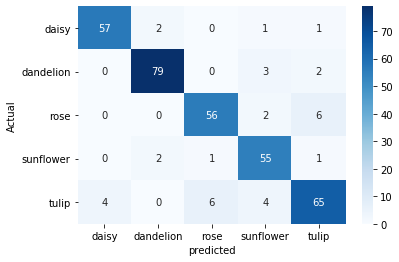

test accuract : 89.9135446685879


In [17]:
import seaborn as sn
import tensorflow as tf
import pandas as pd

model=tf.keras.models.load_model("D:\DATASET\Flower_recognition\saved_model\ResNet50_Flowers.h5")
filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
for _ in range(nb_samples):
    X_test,Y_test=test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df=pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuract : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

                                                                         